# Reconstructing the booking history of the *UHCW* dataset
The [University Hospitals - Coventry & Warwickshire](https://www.uhcw.nhs.uk) (UHCW) has set up an online [portal](https://www.swiftqueue.co.uk/uhcw.php) to facilitate the booking of blood tests appointments in 18 centers around Coventry (UK).  


Available appointments have been recorded in the dataset `appointments.csv`.  A preliminary investigation of the dataset can be found in `UHCW_EDA.ipynb`.

In this notebook we reconstruct the booking history of the appointments and include some visualization.  It uses custom functions and classes from the module `UHCW.py`.

## Imports

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import UHCW

%matplotlib inline

In [2]:
beg_script = datetime.datetime.now()

## Constants

In [3]:
book_color =  plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
cancel_color =  plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

## Data

In [4]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
filename = 'sample_appointments.csv'
foldername = 'Projects/UHCW'
# filename = 'appointments.csv'
# foldername = 'Data/UHCW'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')

raw_data.rename(
    index=str,
    columns={
        'center id': 'id',
        'appointment timestamp': 'appointment',
        'center age group': 'age group',
        'grab timestamp': 'grab'
    },
    inplace=True
)

Time: 23:04:15
Size of data file: 291MB.
Loading data...
CPU times: user 3.87 s, sys: 406 ms, total: 4.28 s
Wall time: 4.28 s


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5117059 entries, 0 to 5117058
Data columns (total 5 columns):
appointment    object
age group      object
id             int64
test type      object
grab           object
dtypes: int64(1), object(4)
memory usage: 234.2+ MB


## Working with a smaller dataset: selecting a test center (and test type)
For illustration purposes (and for speed) we filter for a particular test center and test type (see other notebook `UHCW_EDA.ipynb` for some background):

In [6]:
selected_data = raw_data[
    (raw_data['id'] == 10188)
    & (raw_data['test type'] == "Blood Test")
]

With it we create a `UHCW` object:

In [7]:
%%time
uhcw = UHCW.UHCW(selected_data)

CPU times: user 21.2 s, sys: 313 ms, total: 21.5 s
Wall time: 21.3 s


Information on the center is collected in the attribute `center_info`:

In [8]:
uhcw.center_info

,test types,age group
id,,
10188,[Blood Test],[adult]


## The schedule
The `schedule` attribute of `uhcw` is essentially the data in `selected_data`, after type conversion.  We can visualize the available appointments at the times of data collection:

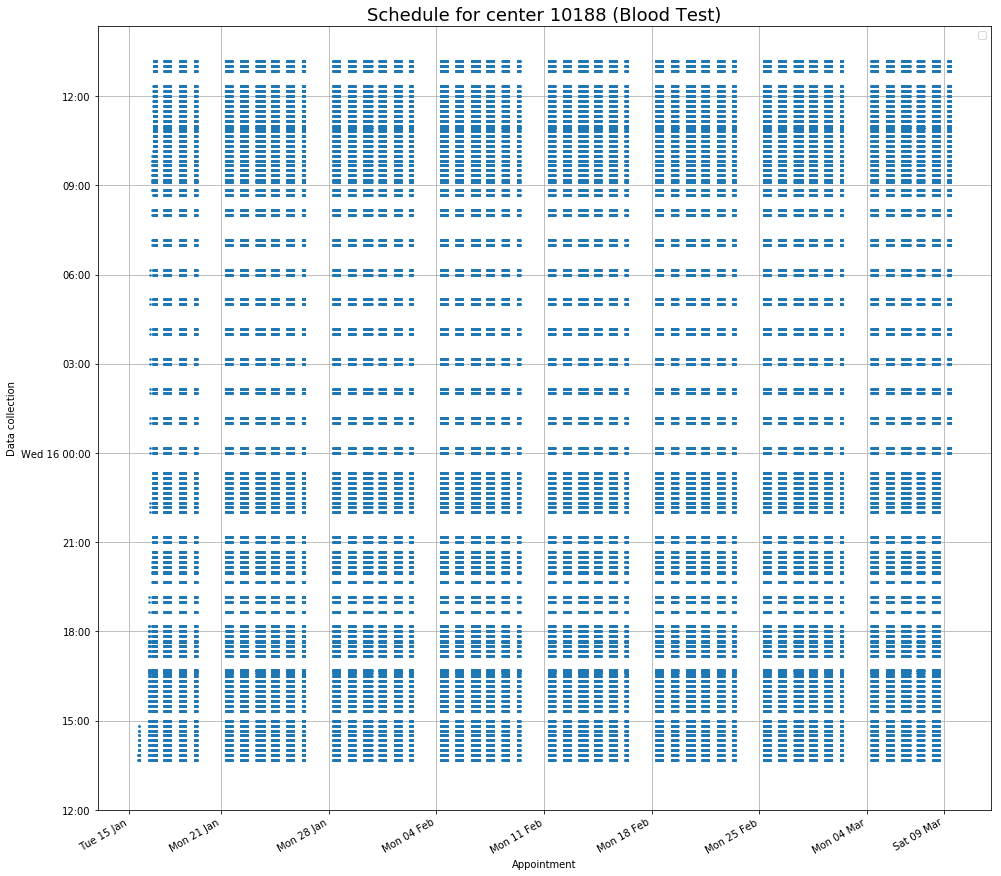

In [9]:
uhcw.plot(feature='schedule', figsize=(16, 16));

We see that most appointments are booked for the following days.  It also appears that new appointments (on 9 March) are posted online at midnight.  

We record the first `grab` timestamp:

In [10]:
start_of_collection = uhcw.schedule['grab'].min()
start_of_collection

Timestamp('2019-01-15 13:40:00+0000', tz='Europe/London')

We also record the *date* of the last appointments in the dataset:

In [11]:
last_appointment_date = uhcw.schedule['appointment'].max().replace(hour=0, minute=0, second=0)
last_appointment_date

Timestamp('2019-03-09 00:00:00+0000', tz='Europe/London')

## The timegrid
In order to reconstruct the booking history, we need to compare the `schedule` with its `timegrid`:

In [12]:
uhcw.build_timegrid()

This is a grid of all `appointment` timestamps at all `grab` timestamps and is accessible as the dataframe `uhcw.timegrid`.  We can visualize it:

In [13]:
# uhcw.plot(feature='timegrid', figsize=(16, 16));

## The naive history
We now compare the `schedule` against the `timegrid` to produce first the **"naive" history**, where the disappearance of an appointment in the dataset is interpreted as a booking, and the reappearance is interpreted as a cancellation:

In [14]:
%%time
uhcw.build_naive_history()

CPU times: user 8.13 s, sys: 200 ms, total: 8.33 s
Wall time: 8.3 s


It is accessible as dataframe `uhcw.naive_history`.

In [15]:
uhcw.naive_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, 4332 to 406117
Data columns (total 5 columns):
id             171 non-null int64
test type      171 non-null object
grab           171 non-null datetime64[ns, Europe/London]
appointment    171 non-null datetime64[ns, Europe/London]
action         171 non-null object
dtypes: datetime64[ns, Europe/London](2), int64(1), object(2)
memory usage: 8.0+ KB


This dataframe is labelled "naive" as it does not give the correct history.  To understand this it is helpful to visualize it:

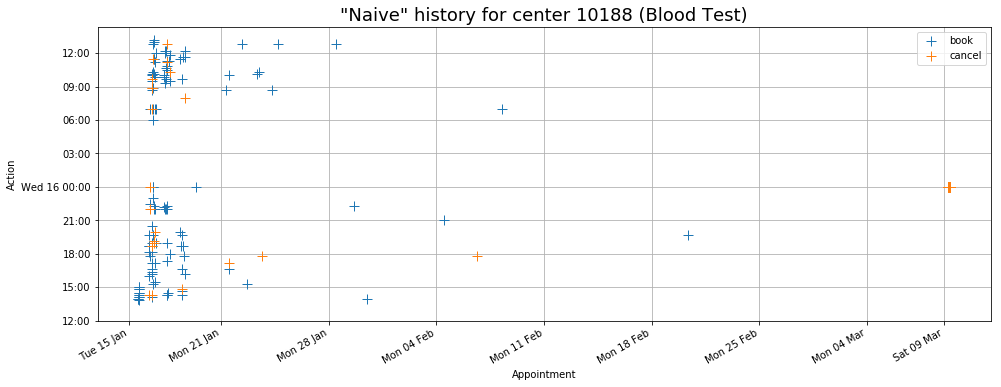

In [16]:
uhcw.plot(feature='naive history');

For example, when an appointment appears for the first time in the dataset it will be interpreted as a cancellation.  In particular, this means that all new appointments for Saturday 9 March (`last_appointment_date`) and posted at midnight on Wednesday 16 January will be interpreted as cancelled.  The (correct) history should eliminate these artefacts.   

## First appearance of appointments

In order to understand how to eliminate artefacts, it will be helpful to calculate the timestamps of `first appearance`:

In [17]:
uhcw.build_first_appearance()

which is accessible as dataframe `uhcw.first_appearance`.  It calculates the first `grab` timestamp associated the `appointment` timestamps.  We can visualize it separately:

In [18]:
#uhcw.plot(feature='first appearance');

or we can superimpose it on the "naive" history:

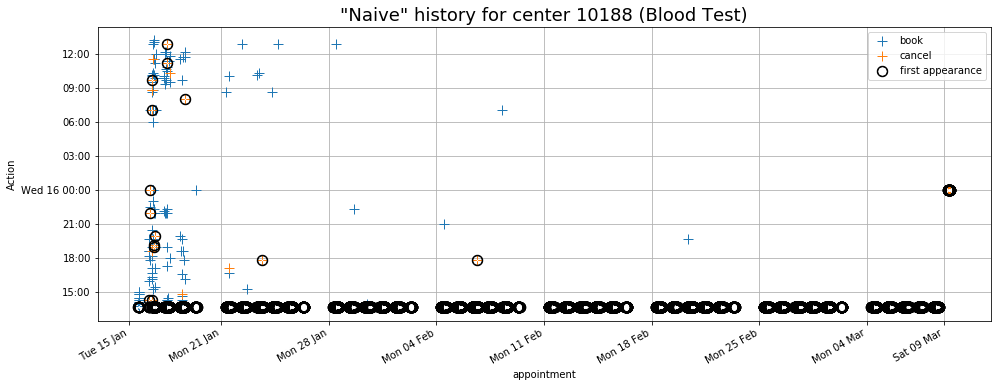

In [19]:
ax, _ = uhcw.plot(feature='naive history');
uhcw.first_appearance.plot(
    x='appointment',
    y='first appearance',
    **{'marker': ".",
       'markersize': 10,
       'markeredgecolor': "k",
       'markeredgewidth': "10",
       'markerfacecolor': "w",
       'markersize': 3,
       "linestyle": ""},
    ax=ax
);
ax.legend(['book', 'cancel', 'first appearance'])
ax.grid()

On first impression, it seems that **all first appearances**, at last those which do not occur on the first collection time nor at midnight on Wednesday 16 January, **coincide with a cancellation** and not a booking.  To verify this conjecture we introduce the timestamps of `first posting`:

In [20]:
uhcw.build_first_posting()

## First posting of appointments
First postings of appointments a accessible as dataframe `uhcw.first_posting`.  It gives the earliest `grab` timestamp of appointments **grouped by their date** rather than their exact timestamps.  (Note that this is slightly different from the date of the `first appearance` timestamps, the difference only occurring on the first day of collection.)  

Working for the moment with bookings, we compare `first posting` timestamps against `grab` timestamps:

In [21]:
naive_booked = uhcw.naive_history.loc[
    (uhcw.naive_history['action'] == 'book'),
    uhcw.naive_history.columns
]
naive_booked['appointment date'] = naive_booked['appointment'].apply(
    lambda ts: ts.replace(hour=0, minute=0, second=0)
)

naive_booked_against_first_posting = pd.merge(
    left=naive_booked,
    right=uhcw.first_posting,
    left_on=['id', 'test type', 'grab', 'appointment date'],
    right_on=['id', 'test type', 'first posting', 'appointment date'],
    how='left'
)
naive_booked_against_first_posting.loc[naive_booked_against_first_posting['first posting'].notna(), :]

,id,test type,grab,appointment,action,appointment date,first posting


The resulting dataframe is empty, showing that none of the bookings coincide with their first appearance.  In other words, **there are no artefacts on bookings**.  

We now return to cancellations:

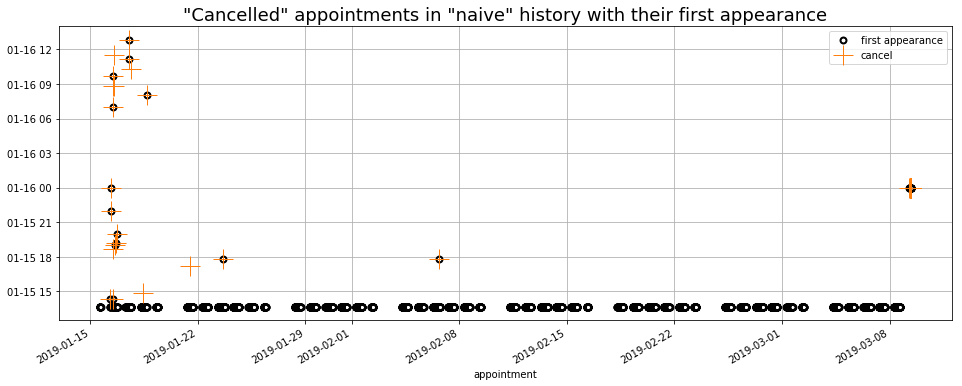

In [22]:
naive_cancelled = uhcw.naive_history.loc[
    (uhcw.naive_history['action'] == 'cancel'),
    uhcw.naive_history.columns
]
naive_cancelled['appointment date'] = naive_cancelled['appointment'].apply(
    lambda ts: ts.replace(hour=0, minute=0, second=0)
)

ax = uhcw.first_appearance.plot(
    x='appointment',
    y='first appearance',
    **{'marker': ".",
       'markersize': 4,
       'markeredgecolor': "k",
       'markeredgewidth': 6,
       'markerfacecolor': "w",
       "linestyle": ""},
    figsize=(16, 6)
);

naive_cancelled.plot(
    x='appointment',
    y='grab',
    **{'marker': "+",
       'markersize': 20,
       'markeredgecolor': cancel_color,
       'markeredgewidth': 1,
       # 'markerfacecolor': "w",
       "linestyle": ""},
    figsize=(16, 6),
    ax=ax
)

ax.set_title('"Cancelled" appointments in "naive" history with their first appearance', fontsize=18)
ax.legend(['first appearance', 'cancel'])
ax.grid()

It is reasonable to interpret the cancellations of the appointments for Saturday 9 March and occurring at midnight on Wednesday 16 January as artefacts.  On the other hand, it is quite likely that most, if not all, other cancellations, most of which coincide with their first appearance, are genuine cancellations.  Thus we retain only those cancelled appointments whose first *posting* timestamp, rather than first *appearance* timestamp, does not agree with their `grab` timestamp:

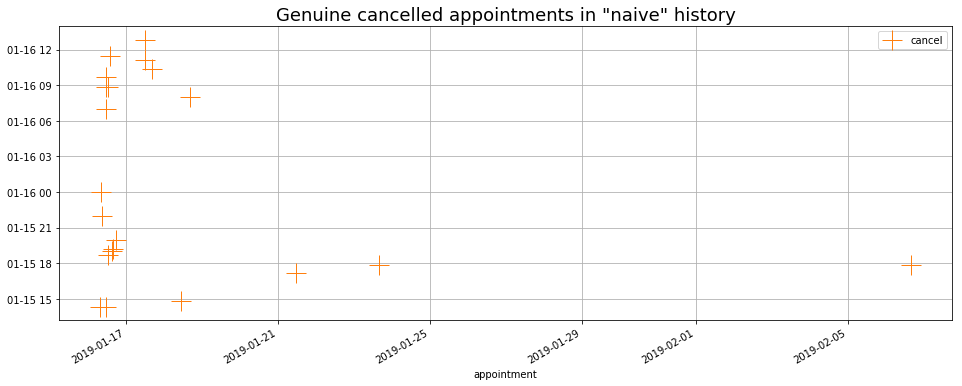

In [23]:
genuine_cancelled = pd.merge(
    left=naive_cancelled,
    right=uhcw.first_posting,
    left_on=['id', 'test type', 'grab', 'appointment date'],
    right_on=['id', 'test type', 'first posting', 'appointment date'],
    how='left',
    indicator=True
)
genuine_cancelled = genuine_cancelled.loc[genuine_cancelled['first posting'].isna(), :]


ax = genuine_cancelled.plot(
    x='appointment',
    y='grab',
    **{'marker': "+",
       'markersize': 20,
       'markeredgecolor': cancel_color,
       'markeredgewidth': 1,
       # 'markerfacecolor': "w",
       "linestyle": ""},
    figsize=(16, 6)
)

ax.set_title('Genuine cancelled appointments in "naive" history', fontsize=18)
ax.legend(['cancel'])
ax.grid()

## The history
The above is summarized in the `history` attribute:

In [ ]:
uhcw.build_history()

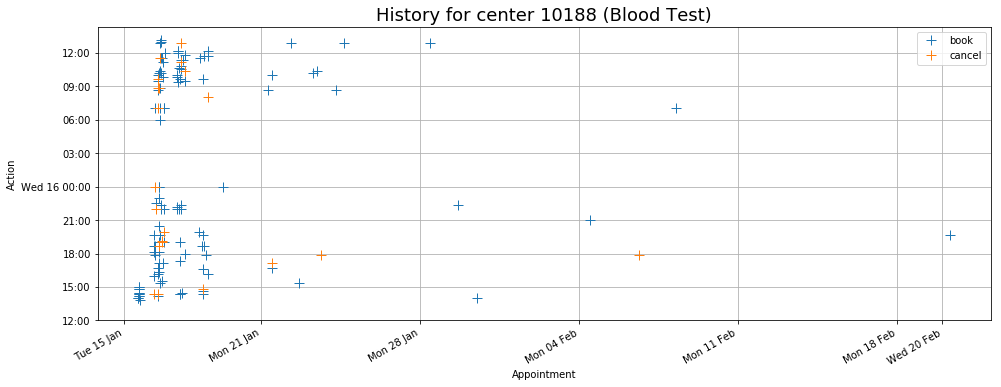

In [26]:
uhcw.plot(feature='history', savefigure=True);

In [25]:
end_script = datetime.datetime.now()
run_time = end_script - beg_script
#run_time
print("This script ran for: {0}min {1}sec.".format(run_time.seconds//60, run_time.seconds%60))

This script ran for: 0min 50sec.
